In [100]:
from gensim.models import Word2Vec
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.cluster import KMeans
import numpy as np
import copy
from math import *
import matplotlib.pyplot as plt

In [101]:
%matplotlib inline

# Data Loading

In [4]:
# fetching the data and get top categories data
data_set = fetch_20newsgroups(subset='all')
names = list(data_set.target_names)
categorized_data = {}
for idx in data_set.target:
    if names[idx] in categorized_data:
        categorized_data[names[idx]] += 1
    else:
        categorized_data[names[idx]] = 1

top_categories = sorted(categorized_data, key=categorized_data.__getitem__, reverse=True)[:10]
top_data = fetch_20newsgroups(subset='all', categories=top_categories)

In [93]:
# get the original labels of the data
original_label = top_data.target

In [19]:
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
table = str.maketrans('', '', string.punctuation)

In [17]:
documents = []

In [20]:
# preprocssing of the data by tokenizing, removing punctuation, stemming and removing stop words
for data in top_data.data:
    tokens = word_tokenize(data)
    stripped = [w.translate(table) for w in tokens]
    stemmed = [porter.stem(word) for word in stripped]
    words = [word for word in stemmed if word.isalpha()]
    words = [w for w in words if not w in stop_words]
    documents.append(words)

# Convert to Word2Vec

In [74]:
# buildup word2vec model
model = Word2Vec(documents, size=300, window=5, workers=4, min_count=1)

In [75]:
# vocabularies
word_vectors = model.wv

In [76]:
data_list = []
for doc in documents:
    doc = [word for word in doc if word in word_vectors] # ruled out the words which are not in vocabulary
    avg = np.mean(model[doc], axis=0) # get the average of the vector
    data_list.append(avg)

C:\Users\mainu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [77]:
data_list = np.array(data_list)

# k-Means

In [31]:
# for choosing k number of centroids from given dataset randomly
def choose_random_centroids(data, k):
    n_samples, n_features = np.shape(data)
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroid = data[np.random.choice(range(n_samples))]
        centroids[i] = centroid
    return centroids

In [32]:
# calculates euclidean distance between 2 vectors
def calculate_euclidean_distance(x1, x2):
    distance = 0
    for i in range(len(x1)):
        distance += pow((x1[i] - x2[i]), 2)
    return distance

In [33]:
# determines the nearest centroid for a sample data point
def find_nearest_centroid(sample, centroids):
    nearest_cent = 0
    nearest_dist = float('inf')
    for i, centroid in enumerate(centroids):
        distance = calculate_euclidean_distance(sample, centroid)
        if distance < nearest_dist:
            nearest_cent = i
            nearest_dist = distance
    return nearest_cent

In [34]:
# creating clusters assigning the data points to it nearest centroids
def create_clusters(centroids, data, k):
    n_samples = np.shape(data)[0]
    clusters = []
    for i in range(k):
        clusters.append([])
    for sample_i, sample in enumerate(data):
        centroid_i = find_nearest_centroid(sample, centroids)
        clusters[centroid_i].append(sample_i)
    return clusters

In [35]:
# calculate the centroids of a given cluster by taking its mean
def calculate_centroids(clusters, data, num_k):
    features = np.shape(data)[1]
    centroids = np.zeros((num_k, features))
    for idx, cluster in enumerate(clusters):
        centroid = np.mean(data[cluster], axis=0)
        centroids[idx] = centroid
    return centroids

In [36]:
# assign lables to the points of the clusters
def get_cluster_labels(clusters, data):
    y_pred = np.zeros(np.shape(data)[0])
    for cluster_i, cluster in enumerate(clusters):
        for sample_i in cluster:
            y_pred[sample_i] = cluster_i
    return y_pred

In [87]:
# applying k-means on a given dataset
def apply_k_means(data, num_k, max_iter):
    centroids = choose_random_centroids(data, num_k)
    for iter in range(max_iter):
        clusters = create_clusters(centroids, data, num_k)
        prev_centroids = centroids
        centroids = calculate_centroids(clusters, data, num_k)
        difference = centroids - prev_centroids
        
        if not difference.any():
            break
    return get_cluster_labels(clusters, data), centroids, clusters

In [112]:
"""
Calcultaes entropy of the clustering. First it creates distribution of classes for each cluster, then it clacultaes entropy for each cluster summing up the probability of
each class mulitplied by the log of the that probability. Finally the weighted average of the entropy over the clusters is measured. 
"""
def calculate_entropy(original_label, predicted_lables, num_k):
    unique_labels, counts_labels = np.unique(original_label, return_counts=True)
    original_label_count = dict.fromkeys(unique_labels, 0)
    label_count_list = [copy.deepcopy(original_label_count) for i in range(num_k)]
    total_data = len(original_label)

    for idx in range(len(predicted_lables)):
        label_count_list[int(predicted_lables[idx])][int(original_label[idx])] += 1

    total_entropy = 0
    for item in label_count_list:
        cluster_entropy = 0
        weighted_entropy = 0
        item_sum = sum(item.values())
        for key, value in item.items():
            try:
                div_value = float(value / item_sum)
            except Exception as e:
                div_value = 0
            try:
                log_value = log(div_value, 2)
            except Exception as e:
                log_value = 0
            mul_value = (-1) * div_value * log_value
            cluster_entropy += mul_value
        weighted_entropy = cluster_entropy * (item_sum / total_data)
        total_entropy += weighted_entropy

    return total_entropy

In [113]:
"""
Calculating SSE taking the sum of the squared distance of each datapoint from its cluster's centroid
"""
def calculate_sse(data, predicted_cluster, predicted_centroids, num_k):
    sse = 0
    for item in range(len(predicted_cluster)):
        k = 0
        while k <= num_k:
            if predicted_cluster[item] == k:
                sse += calculate_euclidean_distance(data[item], predicted_centroids[k])
                break
            k += 1
    return sse

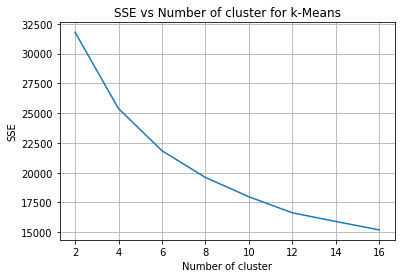

In [102]:
sse_score = {}
entropy = {}
for k in range(2, 18, 2):
    predicted_labels, centroids, clusters = apply_k_means(data_list, k, 50)
    sse_score[k] = calculate_sse(data_list, predicted_labels, centroids, k)
    entropy[k] = calculate_entropy(original_label, predicted_labels, k)

plt.figure()
plt.plot(list(sse_score.keys()), list(sse_score.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title("SSE vs Number of cluster for k-Means")
plt.grid(True)
plt.show()

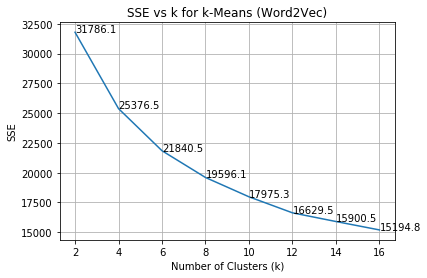

In [120]:
fig, ax = plt.subplots()
ax.plot(list(sse_score.keys()), list(sse_score.values()))
ax.set_xlabel("Number of Clusters (k)")
ax.set_ylabel("SSE")
ax.set_title("SSE vs k for k-Means (Word2Vec)")
for i, txt in enumerate(sse_score.values()):
    ax.annotate("{0:.1f}".format(txt), (list(sse_score.keys())[i], list(sse_score.values())[i]))
plt.grid(True)
plt.show()

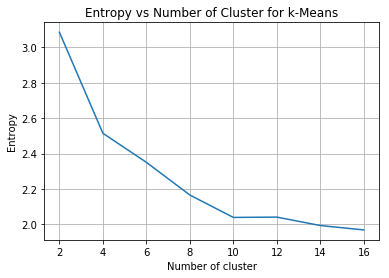

In [103]:
plt.figure()
plt.plot(list(entropy.keys()), list(entropy.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Entropy")
plt.title("Entropy vs Number of Cluster for k-Means")
plt.grid(True)
plt.show()

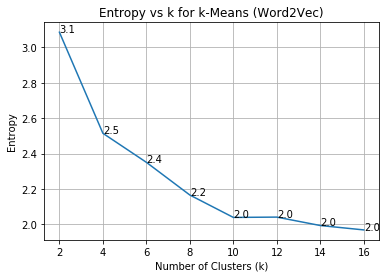

In [119]:
fig, ax = plt.subplots()
ax.plot(list(entropy.keys()), list(entropy.values()))
ax.set_xlabel("Number of Clusters (k)")
ax.set_ylabel("Entropy")
ax.set_title("Entropy vs k for k-Means (Word2Vec)")
for i, txt in enumerate(entropy.values()):
    ax.annotate("{0:.1f}".format(txt), (list(entropy.keys())[i], list(entropy.values())[i]))
plt.grid(True)
plt.show()

# Bisecting k-Means

In [106]:
"""Calculate SSE for a single cluster"""
def calculate_single_sse(data, centroids):
    sse = 0
    for item in range(len(data)):
        sse += calculate_euclidean_distance(data[item], centroids)
    return sse

In [104]:
"""
At first it applies basic k-mean on the given data and calculates sse of the two clusters. Clusters with the larger sse is then selected for further bisection. It iteratively
bisects the cluster before number of clusters becomes equal to k
"""
def bisecting_kmeans(data, num_k):
    data_clusters_list = []
    predicted_labels, centroids, clusters = apply_k_means(data, 2, 100)
    bisected_clusters = [[] for i in range(len(clusters))]
    for cluster_i, cluster in enumerate(clusters):
        for sample_i in cluster:
            bisected_clusters[cluster_i].append(data[sample_i])
    for i in range(len(clusters)):
        data_clusters = {}
        data_clusters['sse'] = calculate_single_sse(bisected_clusters[i], centroids[i])
        data_clusters['cluster'] = bisected_clusters[i]
        data_clusters['cluster_idx'] = clusters[i]
        
        data_clusters_list.append(data_clusters)
    
    if num_k == 2:
        return data_clusters_list
    else:
        while len(data_clusters_list) != num_k:
            data_clusters_list = sorted(data_clusters_list, key=lambda k: k['sse'], reverse=True)
            selected_data = np.array(data_clusters_list[0]['cluster'])
            data_clusters_list = data_clusters_list[1:]
            predicted_labels, centroids, clusters = apply_k_means(selected_data, 2, 30) 
            bisected_clusters = [[] for i in range(len(clusters))]
            for cluster_i, cluster in enumerate(clusters):
                for sample_i in cluster:
                    bisected_clusters[cluster_i].append(data[sample_i])
                    
            for i in range(len(clusters)):
                data_clusters = {}
                data_clusters['sse'] = calculate_single_sse(bisected_clusters[i], centroids[i])
                data_clusters['cluster'] = bisected_clusters[i]
                data_clusters['cluster_idx'] = clusters[i]
                data_clusters_list.append(data_clusters)
                
        return data_clusters_list

In [107]:
def total_sse(cl):
    total_sse = 0
    for item in cl:
        total_sse += item['sse']
    return total_sse

In [109]:
"""Calculate the total entropy of the clusters after a single run"""
def total_entropy(cl, original_labels, word_vectorized, num_k):
    predicted_label = [0 for i in range(word_vectorized.shape[0])]
    k = 0
    for item in cl:
        idx = item['cluster_idx']
        for id in idx:
            predicted_label[id] = k
        k += 1
    return calculate_entropy(original_labels, predicted_label, num_k)

for k= 2 completed
31786.102961734738 3.08480685619494
for k= 4 completed
36211.24575713043 3.3205003794999235
for k= 6 completed
49689.704619255106 3.320437630752435
for k= 8 completed
48314.09316415337 3.3186264011596953
for k= 10 completed
46288.00696144498 3.3182037962802036
for k= 12 completed
46787.29288668226 3.3154157186461837
for k= 14 completed
47430.739268309364 3.313666947023523
for k= 16 completed
46413.31352243407 3.3110789823689735


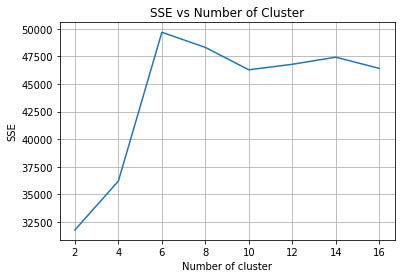

In [116]:
sse_score_or = {}
entropy_sc = {}
for k in range(2, 18, 2):
    cluster_set = bisecting_kmeans(data_list, k)
    sse_score_or[k] = total_sse(cluster_set)
    entropy_sc[k] = total_entropy(cluster_set, original_label, data_list, k)
    print("for k= " + str(k) + " completed")
    print(sse_score_or[k], entropy_sc[k])

plt.figure()
plt.plot(list(sse_score_or.keys()), list(sse_score_or.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title("SSE vs Number of Cluster")
plt.grid(True)
plt.show()

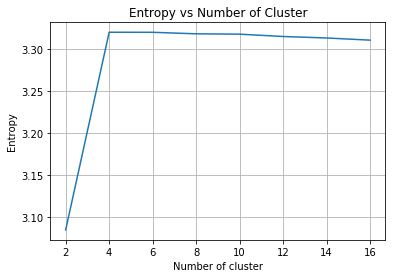

In [117]:
plt.figure()
plt.plot(list(entropy_sc.keys()), list(entropy_sc.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Entropy")
plt.title("Entropy vs Number of Cluster")
plt.grid(True)
plt.show()

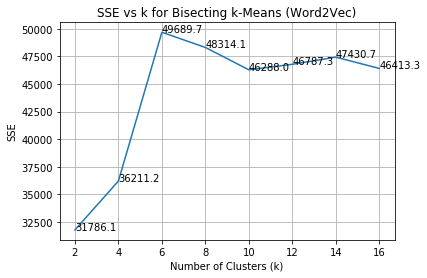

In [121]:
fig, ax = plt.subplots()
ax.plot(list(sse_score_or.keys()), list(sse_score_or.values()))
ax.set_xlabel("Number of Clusters (k)")
ax.set_ylabel("SSE")
ax.set_title("SSE vs k for Bisecting k-Means (Word2Vec)")
for i, txt in enumerate(sse_score_or.values()):
    ax.annotate("{0:.1f}".format(txt), (list(sse_score_or.keys())[i], list(sse_score_or.values())[i]))
plt.grid(True)
plt.show()

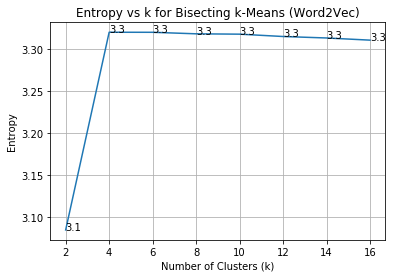

In [122]:
fig, ax = plt.subplots()
ax.plot(list(entropy_sc.keys()), list(entropy_sc.values()))
ax.set_xlabel("Number of Clusters (k)")
ax.set_ylabel("Entropy")
ax.set_title("Entropy vs k for Bisecting k-Means (Word2Vec)")
for i, txt in enumerate(entropy_sc.values()):
    ax.annotate("{0:.1f}".format(txt), (list(entropy_sc.keys())[i], list(entropy_sc.values())[i]))
plt.grid(True)
plt.show()

# DBSCAN

In [123]:
def euclidean_distance(x1, x2):
    distance = 0
    for i in range(len(x1)):
        distance += pow((x1[i] - x2[i]), 2)
    return distance

In [125]:
def get_neighbors(dataset, sample_i, eps):
    neighbors = []
    idxs = np.arange(len(dataset))
    for i, sample in enumerate(dataset[idxs != sample_i]):
        distance = euclidean_distance(dataset[sample_i], sample)
        if distance < eps:
            neighbors.append(i)
    return np.array(neighbors)

In [126]:
def expand_cluster(sample_i, neighbors, visited_samples, eps, min_samples):
    cluster = [sample_i]
    for neighbor_i in neighbors:
        if not neighbor_i in visited_samples:
            visited_samples.append(neighbor_i)
            neighbors[neighbor_i] = get_neighbors(dataset, neighbor_i, eps)
            if len(neighbors[neighbor_i]) >= min_samples:
                expanded_cluster = expand_cluster(neighbor_i, neighbors[neighbor_i], visited_samples, eps, min_samples)
                cluster = cluster + expanded_cluster
            else:
                cluster.append(neighbor_i)
    return cluster

In [128]:
def get_cluster_labels(dataset, clusters):
    labels = np.full(shape=dataset.shape[0], fill_value=len(clusters))
    for cluster_i, cluster in enumerate(clusters):
        for sample_i in cluster:
            labels[sample_i] = cluster_i
    return labels

In [129]:
def apply_dbscan(dataset, eps, min_samples):
    clusters = []
    visited_samples = []
    neighbors = {}
    n_samples = np.shape(dataset)[0]
    for sample_i in range(n_samples):
        if sample_i in visited_samples:
            continue
        neighbors[sample_i] = get_neighbors(sample_i, dataset, eps)
        if len(neighbors[sample_i]) >= min_samples:
            visited_samples.append(sample_i)
            new_cluster = expand_cluster(sample_i, neighbors[sample_i], visited_samples, eps, min_samples)
            clusters.append(new_cluster)

    cluster_labels = get_cluster_labels(dataset, clusters)
    return cluster_labels

In [146]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import math
from math import *
import copy
# from dbscan import DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
import pandas as pd

In [147]:
data_set = fetch_20newsgroups(subset='all')
names = list(data_set.target_names)
categorized_data = {}
for idx in data_set.target:
    if names[idx] in categorized_data:
        categorized_data[names[idx]] += 1
    else:
        categorized_data[names[idx]] = 1

In [148]:
top_categories = sorted(categorized_data, key=categorized_data.__getitem__, reverse=True)[:10]
top_data = fetch_20newsgroups(subset='all', categories=top_categories)
labels_true = top_data.target

In [149]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.5, max_features = 10000, min_df = 2, stop_words = 'english', use_idf = True)
tfidf_vectorized = tfidf_vectorizer.fit_transform(top_data.data)
word_vectorized = tfidf_vectorized.toarray()

In [152]:
labels = apply_dbscan(word_vectorized, 1.0, 10)

In [153]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [155]:
def calculate_entropy(original_label, predicted_lables, num_k):
    unique_labels, counts_labels = np.unique(original_label, return_counts=True)
    original_label_count = dict.fromkeys(unique_labels, 0)
    label_count_list = [copy.deepcopy(original_label_count) for i in range(num_k)]
    total_data = len(original_label)

    for idx in range(len(predicted_lables)):
        label_count_list[int(predicted_lables[idx])][int(original_label[idx])] += 1

    total_entropy = 0
    for item in label_count_list:
        cluster_entropy = 0
        weighted_entropy = 0
        item_sum = sum(item.values())
        for key, value in item.items():
            try:
                div_value = float(value / item_sum)
            except Exception as e:
                div_value = 0
            try:
                log_value = log(div_value, 2)
            except Exception as e:
                log_value = 0
            mul_value = (-1) * div_value * log_value
            cluster_entropy += mul_value
        weighted_entropy = cluster_entropy * (item_sum / total_data)
        total_entropy += weighted_entropy

    return total_entropy

In [156]:
def calculate_single_sse(data, centroids):
    sse = 0
    for item in range(len(data)):
        sse += calculate_euclidean_distance(data[item], centroids)
    return sse

In [157]:
def calculate_sse_entroyp(n_clusters_, lables, word_vectorized):
    original = []
    predicted = []
    keys = range(n_clusters_)
    data = dict.fromkeys(keys, [])
    for idx in range(len(labels)):
        if labels[idx] != -1:
            original.append(labels_true[idx])
            predicted.append(labels[idx])
            data[int(labels[idx])].append(word_vectorized[idx])
    
    sse = 0
    for idx in range(len(data)):
        centroid = np.mean(data[idx], axis=0)
        sse += calculate_single_sse(data[idx], centroid)
    entropy = calculate_entropy(original, predicted, n_clusters_)
    return sse, entropy

In [159]:
sse, entropy = calculate_sse_entroyp(n_clusters_, labels, word_vectorized)